## Generate an ellipse

In [32]:
import pandas as pd
import geopandas as gpd

def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    # if len(vertices) == dnumber:
    #     return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0) 
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count-1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count+1))
    if len(interpolated_geom.exterior.coords[:-1]) == vertex_count+1:
        interpolated_geom = Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count-1))

    return interpolated_geom

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [make_ccw(interpolated_geoms[0]).exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    # for vertices in align_vertices(np.array(interpolated_vertices)):
    #     poly = Polygon(vertices)
    #     geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, rng, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = rng.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = rng.normal(mu, sigma)
        randy = rng.normal(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def sample_windspeed(loc, sigma, rng):
    ws = rng.normal(loc, sigma)
    if ws < 0:
        ws = 0
    return ws
def sample_winddirection(loc, sigma, rng):
    return np.fmod(rng.normal(loc, sigma)+360, 360)


def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_48946/280340247.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling

In [19]:
import numpy as np
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
from shapely.geometry import Polygon , Point

def reproject_geom(geom, from_crs='EPSG:5070', to_crs='EPSG:3857'):
    return gpd.GeoSeries(geom, crs=from_crs).to_crs(to_crs)[0]

def get_wind_params(tix : int):
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

    return wslst[tix], wdlst[tix]

def get_observation(description : str, tix : int):
    ''' Obtain selected observation geometry and datetime
    '''

    if description not in ['Maria2019', 'River2021', 'Bridge2021']:
        raise ValueError(f'description {description} not present in db')
    
    def change_username_jovyan(df, column):
        for ix, row in df.iterrows():
            path_list = row[column].split('/')
            path_list[2] = 'jovyan'
    
            path = ''
            for string in path_list[:-1]:
                path += f'{string}/'
            path += path_list[-1]
    
            df.loc[ix, column] = path  
    
    df = pd.read_pickle('/home/jovyan/data/dftable_06032023.pkl')
    change_username_jovyan(df, 'filepath')
    
    dfrow = df[df['description'] == description].sort_values('datetime').iloc[tix]
    dfgeom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    dfdt = dfrow['datetime']
    
    return dfgeom, dfdt

def forward_pass(x,y, wd, step):
    xfin = []
    yfin = []

    poly = Polygon(zip(x,y))
    for xx, yy in zip(x,y):
        xf = xx + step*np.cos(wd)
        yf = yy + step*np.sin(wd)

        if poly.contains(Point(xf, yf)):
            xfin.append(xx)
            yfin.append(yy)
            continue

        xfin.append(xf)
        yfin.append(yf)

    geom = interpolate_geom(Polygon(zip(xfin,yfin)), len(xfin))

    xfin = geom.exterior.coords.xy[0][:-1].tolist()
    yfin = geom.exterior.coords.xy[1][:-1].tolist()
    
    return xfin, yfin

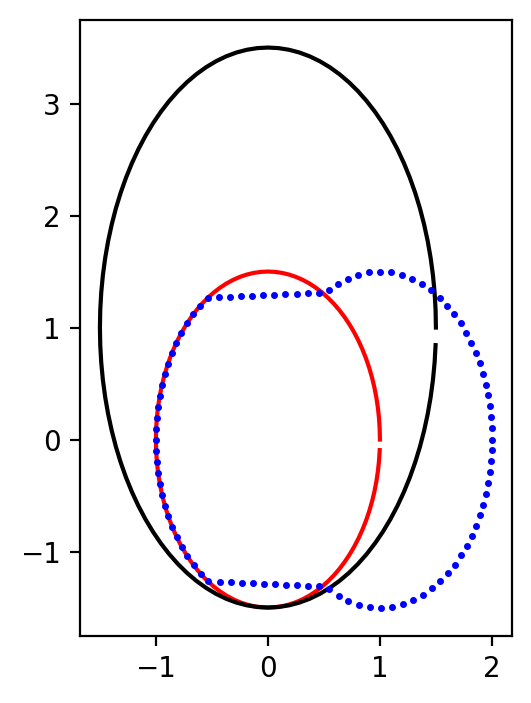

In [20]:
# Calculate forward pass

wdar = np.linspace(0,np.pi,100)

dist = []
for wd in wdar:
    step = 1/np.cos(wd)
    xfin, yfin = forward_pass(x, y, -wd, step)
    if len(yfin) > 0:
        dist.append(max(yfin)-min(yfin))
    else:
        dist.append(0)
        

fig ,ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.plot(x,y, 'r-')
ax.plot(x2,y2,'k-')
# ax.plot(xc,yc, 'bo')
ax.plot(xfin, yfin, 'b.', ms=3)
ax.set_aspect('equal')
# ax.set_ylim(-4,4)
# ax.set_xlim(-4,4)

In [72]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    if show_stdev:
        for vix in range(vcounts):
            print(f'Calculating {vix}/{vcounts}..    ', end='\r', flush=True)
            x,y = X[2*vix,:], X[2*vix+1,:]
            radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
            radstd[vix] = np.std(radius)
        print()
        for vix in range(vcounts):
            print(f'Drawing {vix}/{vcounts}..    ', end='\r', flush=True)
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

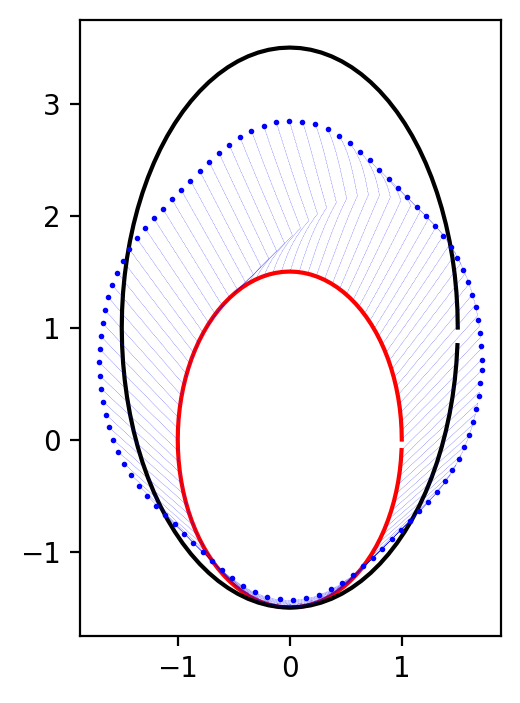

In [97]:
a = 1
b = 1.5
nphi = 100
phi = np.linspace(0,2*np.pi, nphi, endpoint=False)

xc = a*np.cos(-np.pi/2)
yc = b*np.sin(-np.pi/2)

x = a*np.cos(phi)
y = b*np.sin(phi)

x2 = x*1.5
y2 = (b+1)*np.sin(phi)+1

fig ,ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.plot(x,y, 'r-')
ax.plot(x2,y2,'k-')
# ax.plot(xc,yc, 'bo')

wddeg = 45
wdrad = wddeg*np.pi/180
step = 0.01
xfin,yfin = forward_pass(x, y, wdrad, step)
# ax.plot(xfin, yfin, 'b.', ms=3)

xpaths = [[] for i in range(len(x))]
ypaths = [[] for i in range(len(x))]
for tix in range(1,200):
    if tix > 100:
        wdrad = 135*np.pi/180
    xfin,yfin = forward_pass(xfin,yfin, wdrad, step)
    for i in range(len(xfin)):
        xpaths[i].append(xfin[i])
        ypaths[i].append(yfin[i])
        
ax.plot(xfin, yfin, 'b.', ms=2)

for xp, yp in zip(xpaths, ypaths):
    ax.plot(xp, yp, 'b--', lw=0.1)
    
ax.set_aspect('equal')
# ax.set_ylim(-4,4)
# ax.set_xlim(-4,4)

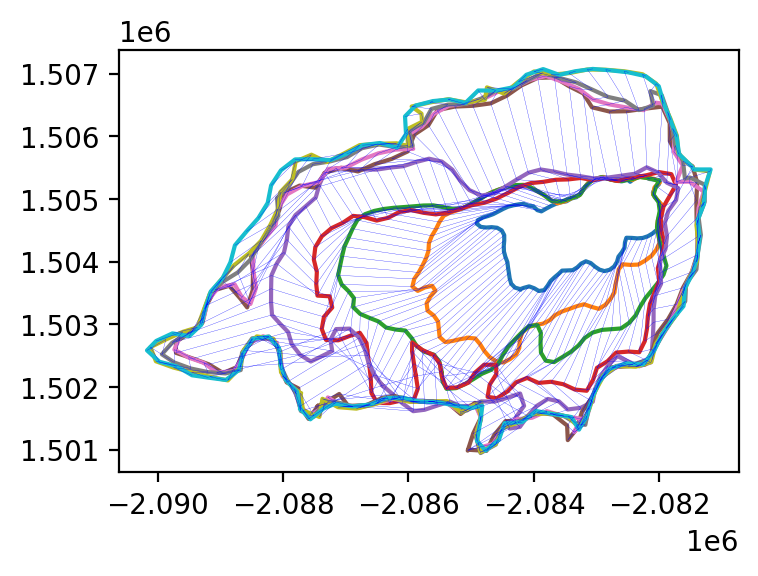

In [90]:
from shapely.geometry import MultiPolygon

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
vertexcount = 100
maria_geoms = [get_observation('Maria2019', i)[0] for i in range(10)]
maria_geoms[5] = maria_geoms[5].geoms[0]

interpolated_geoms = [interpolate_geom(maria_geoms[i], vertexcount) for i in range(len(maria_geoms))]
interpolated_geoms = [align_geoms([interpolated_geoms[0], geom], vertexcount)[1] for geom in interpolated_geoms]

xpaths = [[] for i in range(vertexcount)]
ypaths = [[] for i in range(vertexcount)]

for i in range(len(interpolated_geoms)):
    xvs = interpolated_geoms[i].exterior.coords.xy[0][:-1].tolist()
    yvs = interpolated_geoms[i].exterior.coords.xy[1][:-1].tolist()

    for ix in range(vertexcount):
        xpaths[ix].append(xvs[ix])
        ypaths[ix].append(yvs[ix])

for geom in interpolated_geoms:
    plot_geometry(geom, ax=ax)

for xp, yp in zip(xpaths, ypaths):
    ax.plot(xp, yp, 'b-', lw=0.1)

In [95]:
[len(geom.exterior.coords) for geom in maria_geoms]

[95, 92, 123, 113, 151, 495, 453, 479, 442, 414]